In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pickle
import uproot as ur
import awkward as ak
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#RUN BEFORE#

In [4]:
#RUN AFTER#

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as keras
K = keras.backend

from PionReconstruction.util.Models import *
from PionReconstruction.util.Generators import *
from PionReconstruction.util.Plotting import *


/home/joshualerner/projects/src/hls4ml/hls4ml/converters/__init__.py:25: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [5]:

data_path = '/fast_scratch_1/atlas_images/v01-45/'

cell_geo_path = data_path + 'cell_geo.root'

out_path = '/fast_scratch_1/jlerner/data/'


In [6]:
## Prepare a sample for comparison and normalization if necessary

# with ur.open(data_path + 'pi0/user.angerami.24559740.OutputStream._000232.root') as file:
#     pi0_data = file['EventTree'].arrays(library='ak')
    
# with ur.open(data_path + 'pipm/user.angerami.24559744.OutputStream._000232.root') as file:
#     pipm_data = file['EventTree'].arrays(library='ak')
    
# orig_pred = np.concatenate((ak.flatten(pipm_data['cluster_E']), 
#                             ak.flatten(pi0_data['cluster_E']))).to_numpy()

# orig_target = np.concatenate((ak.flatten(pipm_data['cluster_ENG_CALIB_TOT']), 
#                               ak.flatten(pi0_data['cluster_ENG_CALIB_TOT']))).to_numpy()

In [7]:
norm = 'log' # 'log', 'std', or 'max'
vmax = 128

if norm == 'std':
    scaler = StandardScaler()
elif norm == 'max':
    scaler = 2000
else:
    scaler = None

if isinstance(scaler, type(StandardScaler())):
    sample = orig_target.reshape(-1, 1)
    scaler.fit(sample)

normalizer = (norm, scaler)

In [8]:
preprocess = False
train = False
save = True

In [9]:

quantize = True
data_format = 'xne'

q = ''
if quantize:
    q = 'q'

if train:
    K.clear_session()
    model = GarNetModel(quantize=quantize, vmax=vmax, input_format=data_format)
    model.summary()


In [10]:

train_val_split = 0.8
batch_size = 64

pi0_list = [[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] 
            for i in list(range(11, 113)) + list(range(116, 432))]
pipm_list = [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] 
             for i in list(range(11, 113)) + list(range(116, 432))]

np.random.shuffle(pi0_list)
np.random.shuffle(pipm_list)

train_start = 0
train_end = train_start + int(train_val_split*len(pi0_list))
val_start = train_end
val_end = len(pi0_list)
train_file_list = (pi0_list[train_start:train_end], pipm_list[train_start:train_end])
val_file_list = (pi0_list[val_start:val_end], pipm_list[val_start:val_end])

test_file_list = ([[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] for i in range(432, 464)],
                  [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] for i in range(432, 464)])


In [11]:

name = f'garnet_{normalizer[0]}_{vmax}'

filterfunction = None    
#def filterfunction(data):
#    return data[1][-1] <= np.log(100)/10

train_generator = garnetDataGenerator(train_file_list, 
                                      cell_geo_path, 
                                      batch_size,
                                      normalizer=normalizer,
                                      name=name,
                                      vmax=vmax,
                                      labeled=True,
                                      preprocess=preprocess, 
                                      output_dir=out_path + 'train/',
                                      data_format=data_format,
                                      filterfunc=filterfunction)

if preprocess: cell_geo_path = train_generator.geo_dict

validation_generator = garnetDataGenerator(val_file_list, 
                                           cell_geo_path,
                                           int(batch_size*(1 - train_val_split)/train_val_split),
                                           normalizer=normalizer,
                                           name=name,
                                           vmax=vmax,
                                           labeled=True, 
                                           preprocess=preprocess, 
                                           output_dir=out_path + 'val/',
                                           data_format=data_format,
                                           filterfunc=filterfunction)

test_generator = garnetDataGenerator(test_file_list,
                                     cell_geo_path,
                                     batch_size=20000,
                                     normalizer=normalizer,
                                     name=name,
                                     vmax=vmax,
                                     labeled=True,
                                     preprocess=preprocess,
                                     output_dir=out_path + 'test/',
                                     data_format=data_format,
                                     filterfunc=filterfunction)


In [12]:
if train:
    if normalizer[0] in ['log', 'std']:
        regression_loss = keras.losses.MeanSquaredError()
    else:
        def regression_loss(y_true, y_pred):
            y_true /= normalizer[1]
            return K.mean(K.square((y_true - y_pred) / (y_true + K.epsilon())), axis=-1)

    classification_loss = keras.losses.BinaryCrossentropy()
    
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
    losses = {'regression': regression_loss, 'classification': classification_loss}
    loss_weights = {'regression': 0.99, 'classification': 0.01}
        
    model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights, metrics=['accuracy'])
    
    callbacks = [PrinterCallback(), 
                 keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=10, min_lr=0.0000001, verbose=1),
                 keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, verbose=1)]
    
    history = model.fit(train_generator.generator(), 
                        validation_data=validation_generator.generator(),
                        steps_per_epoch=1200,
                        validation_steps=300,
                        shuffle=True,
                        epochs=200,
                        callbacks=[callbacks],
                        verbose=0)
    history = history.history

In [13]:
if save:
    if train:
        model.save(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}')

        with open(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}/history.pickle', 'wb') as handle:
            pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}/scaler.pickle', 'wb') as handle:
            pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    K.clear_session()
    model = tf.keras.models.load_model(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}', 
                                   custom_objects={"GarNetModel": GarNetModel}, compile=False)

    with open(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}/history.pickle', "rb") as file:
        history = pickle.load(file)
    
    with open(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}/scaler.pickle', "rb") as file:
        scaler = pickle.load(file)

2023-07-31 01:03:52.357493: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-31 01:03:52.357571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8919 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [14]:
x, y = next(test_generator.generator())

In [15]:
import random

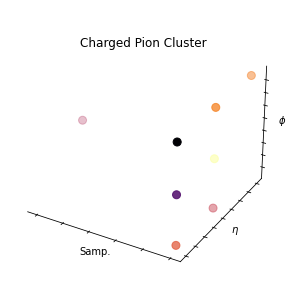

In [16]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
data = x[0][24]
data = data[data[:,3]!=0].reshape(-1,4)
p = ax.scatter3D(data[:,2], data[:,0], data[:,1], s=64, c=data[:,3], cmap='inferno');
ax.grid(False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_xlabel('Samp.', labelpad=-10)
ax.set_ylabel(r'$\eta$', labelpad=-10)
ax.set_zlabel(r'$\phi$', labelpad=-10)
ax.set_title('Charged Pion Cluster', pad=-40)
ax.zaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.xaxis.set_rotate_label(False)
fig.show()

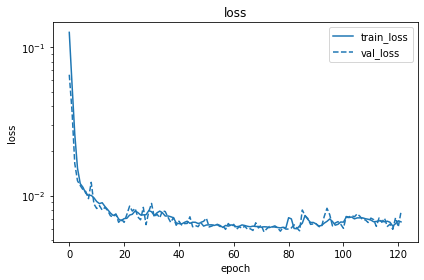

In [17]:
loss_curve = Plotter(training, history=history, metrics=['loss'], scale='log')
loss_curve.show()

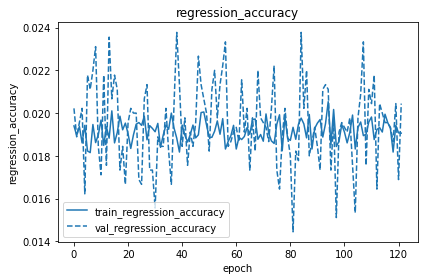

In [18]:
accuracy_curve = Plotter(training, history=history, metrics=['regression_accuracy'])
accuracy_curve.show()

2023-07-31 01:03:58.453927: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


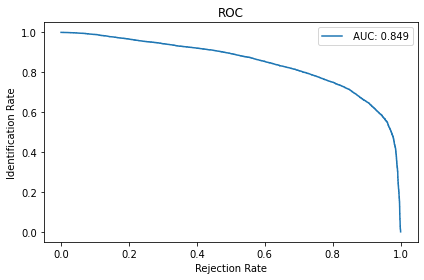

In [19]:
ROC = Plotter(roc, preds=[model.predict(x)[0][:,0]], targets=[y['classification'][:,0]], labels=[''])
ROC.show()

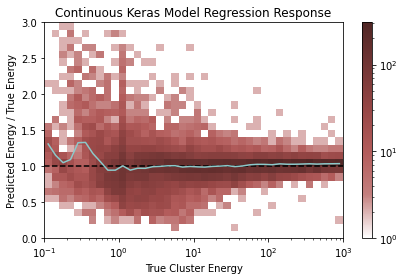

In [20]:
if normalizer[0] == 'log':
    fit_pred = np.exp(model.predict(x)[-1] * 10).reshape(-1,)
    fit_target = np.exp(y['regression'] * 10).reshape(-1,)
elif normalizer[0] == 'std':
    scaler = normalizer[1]
    fit_pred = scaler.inverse_transform(model.predict(x)[-1]).reshape(-1,)
    fit_target = scaler.inverse_transform(np.reshape(y['regression'], (-1, 1))).reshape(-1,)
elif normalizer[0] == 'max':
    fit_pred = model.predict(x)[-1].reshape(-1,) * normalizer[1]
    fit_target = y['regression'].reshape(-1,) * normalizer[1]
else:
    fit_pred = model.predict(x)[-1].reshape(-1,)
    fit_target = y['regression'].reshape(-1,)

reg = Plotter(regResponse, 
              pred=fit_pred, 
              target=fit_target,
              stat=['median'],
              title='Continuous Keras Model Regression Response')
reg.show()

In [21]:
# reg = Plotter(regResponseOverlay,
#               preds=[orig_pred, fit_pred],
#               targets=[orig_target, fit_target],
#               labels=['Pre-Fit', 'Post-Fit'],
#               stat=['mean', 'stdmean'])

In [22]:
K.clear_session()
model = tf.keras.models.load_model(out_path + f'models/GarNet_log_64', 
                                   custom_objects={"GarNetModel": GarNetModel}, compile=False)


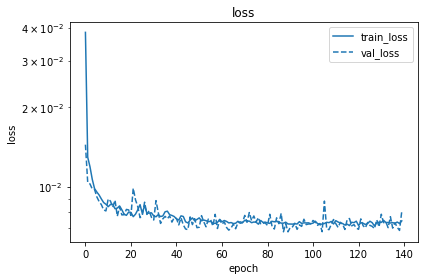

In [23]:
with open(out_path + f'models/qGarNet_log_32/history.pickle', "rb") as file:
        history = pickle.load(file)
        
loss_curve = Plotter(training, history=history, metrics=['loss'], scale='log')
loss_curve.show()

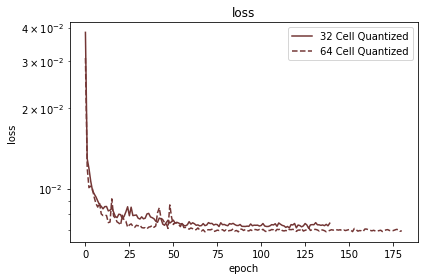

In [24]:
histories = []
preds = []
targets = []
labels = []
for v in [32, 64]:
    name = f'garnet_log_{v}'
    test_generator = garnetDataGenerator(test_file_list,
                                         cell_geo_path,
                                         batch_size=20000,
                                         normalizer=normalizer,
                                         name=name,
                                         vmax=v,
                                         labeled=True,
                                         preprocess=False,
                                         output_dir=out_path + 'test/',
                                         data_format=data_format,
                                         filterfunc=filterfunction)
    x, y = next(test_generator.generator())
    for q in ['q']:
        model = tf.keras.models.load_model(out_path + f'models/{q}GarNet_log_{v}', 
                                           custom_objects={"GarNetModel": GarNetModel}, compile=False)
        preds.append(np.exp(model.predict(x)[-1] * 10).reshape(-1,))
        targets.append(np.exp(y['regression'] * 10).reshape(-1,))
        
        histories.append(pickle.load(open(out_path + f'models/{q}GarNet_log_{v}/history.pickle', "rb")))
        if q=='q':
            labels.append(f'{v} Cell Quantized')
        else:
            labels.append(f'{v} Cell Continuous')
        
loss_curve = Plotter(trainingOverlay, histories=histories, labels=labels, metric='loss', scale='log')
loss_curve.show()

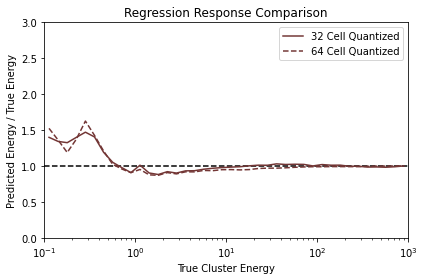

In [25]:
reg = Plotter(regResponseOverlay,
              preds=preds,
              targets=targets,
              labels=labels,
              stat=['median'])
reg.show()